In [1]:
import warnings
import time
from functools import wraps
from collections import Counter


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore")

/kaggle/input/flight-delays-fall-2018/sample_submission.csv.zip
/kaggle/input/flight-delays-fall-2018/flight_delays_train.csv.zip
/kaggle/input/flight-delays-fall-2018/flight_delays_test.csv.zip


In [2]:
DATA_PATH = "/kaggle/input/flight-delays-fall-2018"

train_df = pd.read_csv(f"{DATA_PATH}/flight_delays_train.csv.zip")
test_df = pd.read_csv(f"{DATA_PATH}/flight_delays_test.csv.zip")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


# Preprocessing Data

In [4]:
def preprocessing_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['Month'] = df['Month'].str.split('-', expand=True)[1].astype(int)
    df['DayofMonth'] = df['DayofMonth'].str.split('-', expand=True)[1].astype(int)
    df['DayOfWeek'] = df['DayOfWeek'].str.split('-', expand=True)[1].astype(int)
    df['Flight'] = df['Origin'] + '-' + df['Dest']
    
    df['DepTime'] = df['DepTime'].astype(str)
    df['DepTime'] = pd.to_datetime(df['DepTime'], format='%H%M', errors='coerce')
    df['DepTime'] = df['DepTime'].dt.time

    df['IsWeekend'] = df['DayOfWeek'].isin([6, 7]).astype(int)
    
    return df

train_df_preprocessed = preprocessing_data(train_df)

In [5]:
train_df_preprocessed.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Flight,IsWeekend
0,8,21,7,19:34:00,AA,ATL,DFW,732,N,ATL-DFW,1
1,4,20,3,15:48:00,US,PIT,MCO,834,N,PIT-MCO,0
2,9,2,5,14:22:00,XE,RDU,CLE,416,N,RDU-CLE,0
3,11,25,6,10:15:00,OO,DEN,MEM,872,N,DEN-MEM,1
4,10,7,6,18:28:00,WN,MDW,OMA,423,Y,MDW-OMA,1


In [6]:
num_cols = ['Distance']
cat_cols = list(train_df_preprocessed.drop(columns=num_cols + ['dep_delayed_15min', 'DepTime'], axis=1))

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
])

X_train_transformed = pipeline.fit_transform(train_df_preprocessed.drop('dep_delayed_15min', axis=1))
y = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

In [7]:
y.value_counts()

dep_delayed_15min
0    80956
1    19044
Name: count, dtype: int64

# Target Balancing with SMOTE

<Axes: >

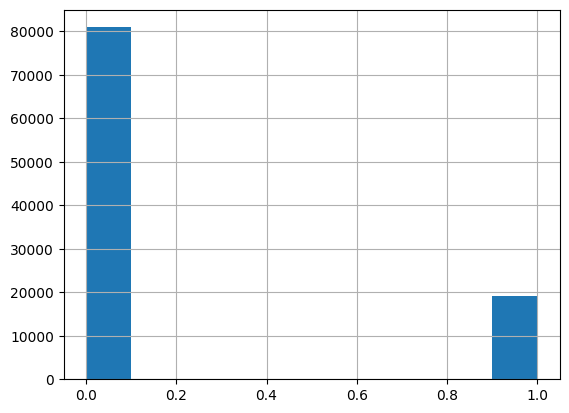

In [8]:
y.hist()

In [9]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X_train_transformed, y)

<Axes: >

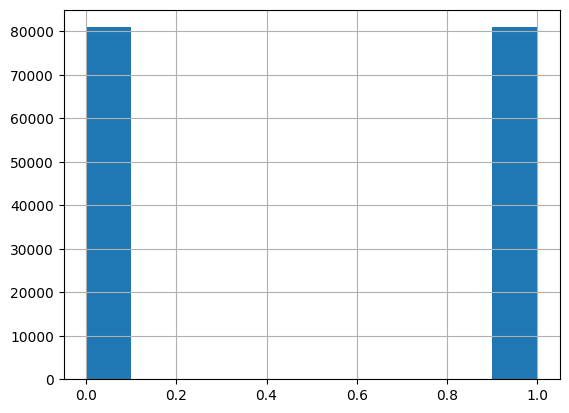

In [10]:
y.hist()

In [11]:
Counter(y)

Counter({0: 80956, 1: 80956})

# Train and Select Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        print(f"{func.__name__} took {time.perf_counter() - start:.2f} seconds")
        return result
    return wrapper

In [14]:
@timeit
def train_and_plot_cm(model):

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    cm.plot()
    plt.show()

              precision    recall  f1-score   support

           0       0.65      0.59      0.62     16192
           1       0.63      0.69      0.66     16191

    accuracy                           0.64     32383
   macro avg       0.64      0.64      0.64     32383
weighted avg       0.64      0.64      0.64     32383



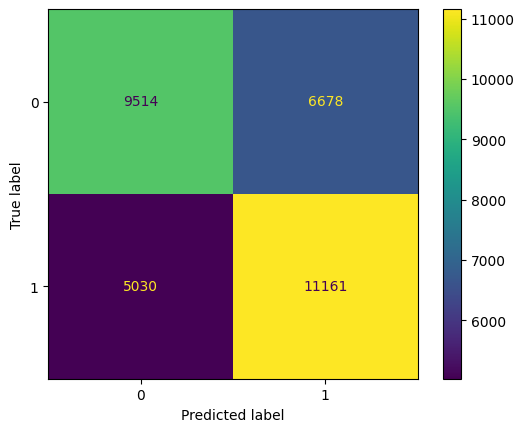

train_and_plot_cm took 1.74 seconds


In [15]:
train_and_plot_cm(LogisticRegression())

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     16192
           1       0.98      0.82      0.89     16191

    accuracy                           0.90     32383
   macro avg       0.91      0.90      0.90     32383
weighted avg       0.91      0.90      0.90     32383



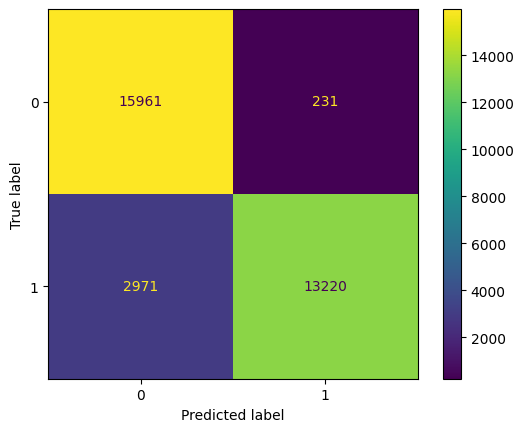

train_and_plot_cm took 386.58 seconds


In [16]:
train_and_plot_cm(RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     16192
           1       1.00      0.75      0.86     16191

    accuracy                           0.87     32383
   macro avg       0.90      0.87      0.87     32383
weighted avg       0.90      0.87      0.87     32383



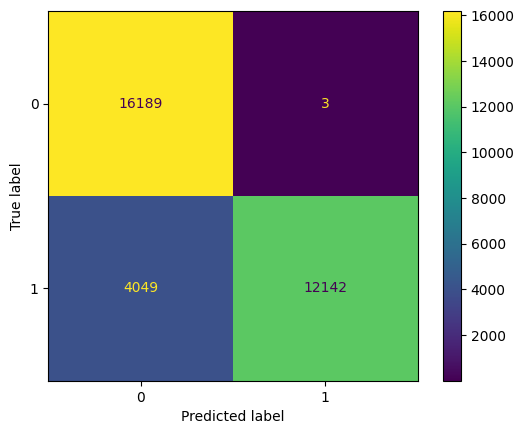

train_and_plot_cm took 5.54 seconds


In [17]:
train_and_plot_cm(XGBClassifier())

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     16192
           1       1.00      0.76      0.86     16191

    accuracy                           0.88     32383
   macro avg       0.90      0.88      0.88     32383
weighted avg       0.90      0.88      0.88     32383



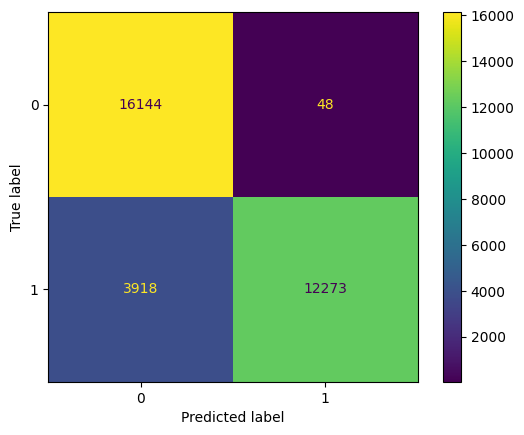

train_and_plot_cm took 88.86 seconds


In [18]:
train_and_plot_cm(CatBoostClassifier(verbose=0))

# Hypertuning

In [19]:
model = {
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(),
    'CatBoostClassifier': CatBoostClassifier(verbose=0)
}

params = {
    'RandomForestClassifier': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    },
    'XGBClassifier': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.3],
        'subsample': [0.8, 1.0]
    },
    'CatBoostClassifier': {
        'iterations': [100, 200],
        'depth': [4, 6],
        'learning_rate': [0.05, 0.1]
    }
}

@timeit
def hypertune_models():
    return  {
        name: GridSearchCV(model, params[name], cv=5, n_jobs=-1, scoring='accuracy').fit(X_train, y_train).best_estimator_
        for name, model in model.items()
    }

best_models = hypertune_models()

hypertune_models took 2356.86 seconds


In [20]:
for name, model in best_models.items():
    
    y_pred = model.predict(X_test)
    print("=" * 60)
    print(f"Modelo: {name}\n")
    print(classification_report(y_test, y_pred))
    print("=" * 60, "\n")

Modelo: RandomForestClassifier

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     16192
           1       0.99      0.81      0.89     16191

    accuracy                           0.90     32383
   macro avg       0.91      0.90      0.90     32383
weighted avg       0.91      0.90      0.90     32383


Modelo: XGBClassifier

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     16192
           1       1.00      0.74      0.85     16191

    accuracy                           0.87     32383
   macro avg       0.90      0.87      0.87     32383
weighted avg       0.90      0.87      0.87     32383


Modelo: CatBoostClassifier

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     16192
           1       1.00      0.73      0.85     16191

    accuracy                           0.87     32383
   macro avg       0.89      0.87      0.86

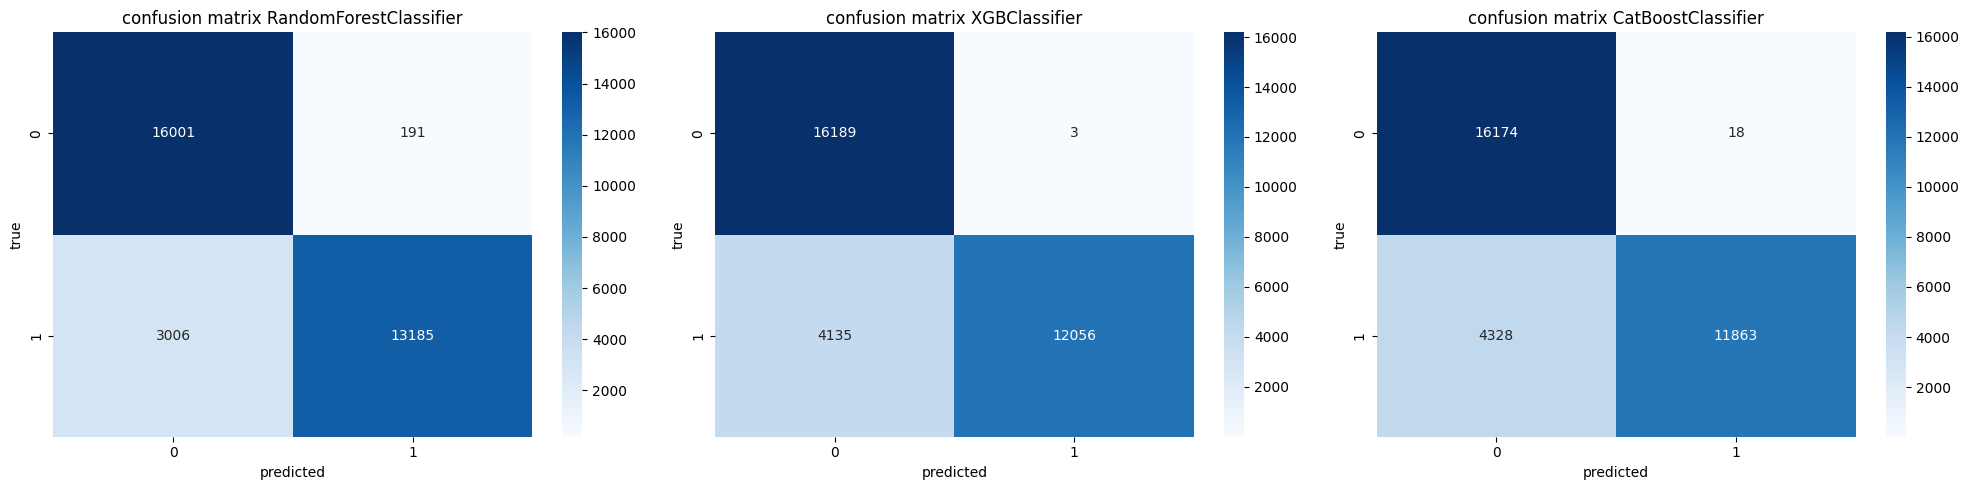

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, (name, model) in zip(axes, best_models.items()):

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
    ax.set_title(f"confusion matrix {name}")
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')

plt.tight_layout()
plt.show()

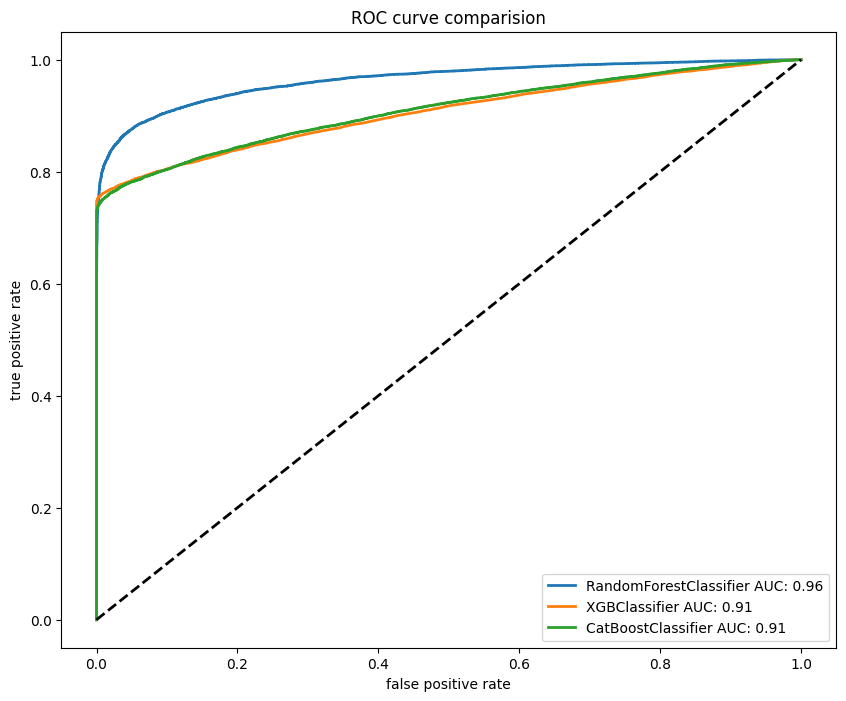

In [22]:
plt.figure(figsize=(10, 8))

for name, model in best_models.items():

    if hasattr(model, 'predict_proba'):
        y_pred = model.predict_proba(X_test)[:, 1]
    else:
        y_pred = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{name} AUC: {auc_score:.2f}")

plt.plot([0, 1], [0, 1], '--k', lw=2)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve comparision')
plt.legend(loc='lower right')
plt.show()

In [23]:
model = best_models['RandomForestClassifier']

test_df_preprocessed = preprocessing_data(test_df)
X_test_tranformed = pipeline.transform(test_df_preprocessed)

test_df_preprocessed['dep_delayed_15min'] = model.predict_proba(X_test_tranformed)[:, 1].round(3)
test_df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258
...,...,...,...,...,...,...,...,...
99995,c-6,c-5,c-2,852,WN,CRP,HOU,187
99996,c-11,c-24,c-6,1446,UA,ORD,LAS,1515
99997,c-1,c-30,c-2,1509,OO,ORD,SGF,438
99998,c-1,c-5,c-5,804,DL,LGA,ATL,761


In [24]:
df_result = test_df_preprocessed[['dep_delayed_15min']].copy()

df_result.reset_index(inplace=True)
df_result.rename(columns={'index': 'id'}, inplace=True)

df_result.to_csv('/kaggle/working/submission.csv', index=False)